In [30]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from IPython.display import display, Image

In [31]:
os.environ["GOOGLE_API_KEY"] = "__GOOGLE_KEY__"
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

In [32]:
class CustomState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

In [39]:
def classification_node(state: CustomState):
    """
    Classify the text into one of the categories: News, Blog, Research, or Other
    """
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification":classification}

def entity_extraction_node(state: CustomState):
    """
    Extract all the entities (Person, Organization, Location, software entities such as products and models, all living or non-living entities) from the text
    """
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(",")
    return {"entities": entities}

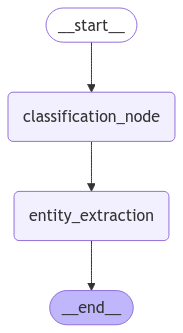

In [40]:
workflow = StateGraph(CustomState)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.set_entry_point("classification_node")
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", END)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))


In [41]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)
print(result["classification"])
print(result["entities"])

News
['OpenAI']
